# Data Description
- **application_{train|test}.csv**
    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.
    
- **bureau.csv**
    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
    
- **bureau_balance.csv**
    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
- **POS_CASH_balance.csv**
    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
- **credit_card_balance.csv**
    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
- **previous_application.csv**
    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.
- **installments_payments.csv**
    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
    - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
- **HomeCredit_columns_description.csv**
    - This file contains descriptions for the columns in the various data files.
    
    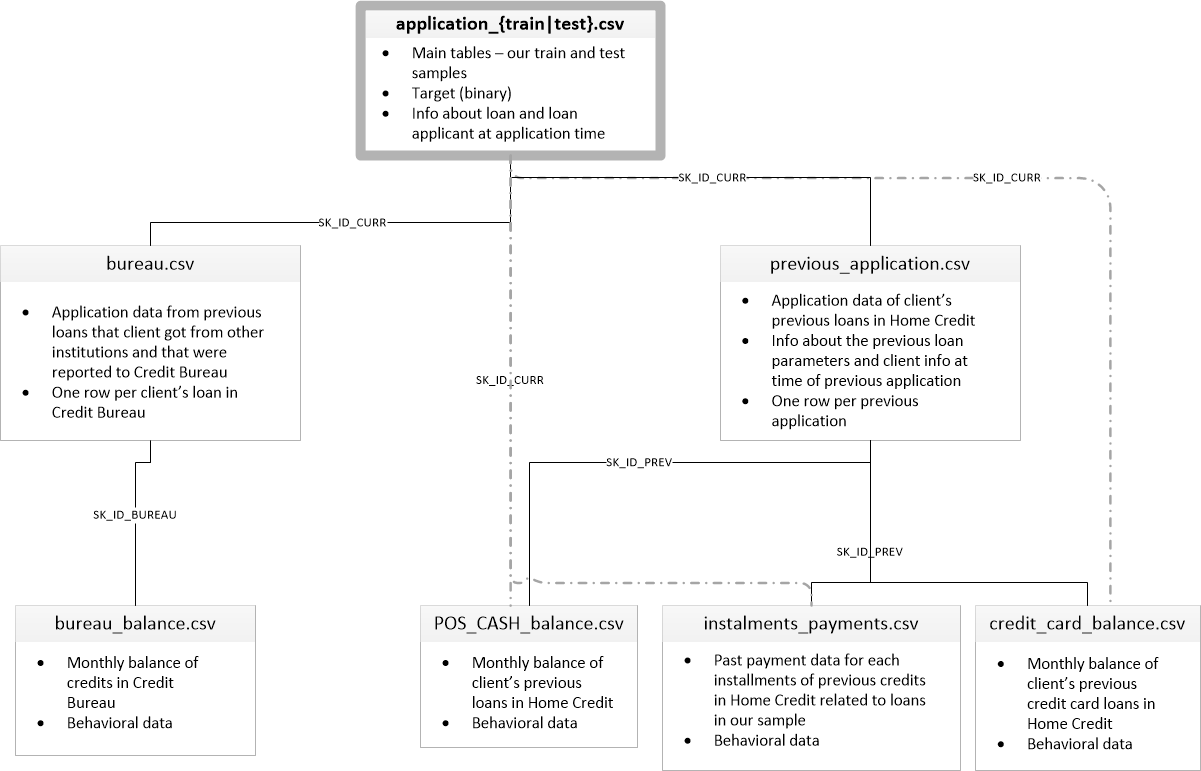


In [1]:
%matplotlib inline



import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import MySQLdb
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

In [2]:
%env SPARK_LOCAL_HOSTNAME=localhost
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[*]")

env: SPARK_LOCAL_HOSTNAME=localhost


In [3]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
path =r'./input/'

In [4]:
filenames = glob.glob(path + "/*.csv")

In [5]:
li = []
for filename in filenames:
    df_filename = pd.read_csv(filename, encoding = "ISO-8859-1")
    li.append(df_filename)

In [6]:
# List files available
print(os.listdir("./input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [7]:
# Shapes of Data
for i in range(len(li)):
    print('Data shape: ','df', i, filenames[i][len(path):-4],'->',li[i].shape)

Data shape:  df 0 application_test -> (48744, 121)
Data shape:  df 1 application_train -> (307511, 122)
Data shape:  df 2 bureau -> (1716428, 17)
Data shape:  df 3 bureau_balance -> (27299925, 3)
Data shape:  df 4 credit_card_balance -> (3840312, 23)
Data shape:  df 5 HomeCredit_columns_description -> (219, 5)
Data shape:  df 6 installments_payments -> (13605401, 8)
Data shape:  df 7 POS_CASH_balance -> (10001358, 8)
Data shape:  df 8 previous_application -> (1670214, 37)
Data shape:  df 9 sample_submission -> (48744, 2)


```I've created a MySQL Database so that I can join tables(Home Credits csv files) that I have multiple criterias.```

I've used the **```script.sql```** file for fetching my dataframe from the database that I've made.
My database is on my ```localhost``` only. However I've creadet an ```SQL dump``` for this for migration purposes or transfer to other host.

But here's the content of the ```script.sql```:

SELECT app_train.*,bureau_loan,bad_debt,active_bureau,delays 

FROM home_credit.application_train app_train

left join (select 
				SK_ID_CURR
                ,count(SK_ID_BUREAU) bureau_loan
                ,sum(case when CREDIT_ACTIVE = 'Bad debt' then 1 else 0 end) bad_debt 
                ,sum(case when CREDIT_ACTIVE = 'Active' then 1 else 0 end) active_bureau
                from home_credit.bureau group by SK_ID_CURR) b 
                
                on b.SK_ID_CURR = app_train.SK_ID_CURR
                
left join (SELECT SK_ID_CURR
					,sum(case when (DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT)>0 then 1 else 0 end) delays 
                    FROM home_credit.installments_payments group by SK_ID_CURR) prev 
                    
                    on prev.SK_ID_CURR = app_train.SK_ID_CURR;
                    
                    
                  

In [8]:
# Read the sql file Train Data
query = open('script.sql', 'r')

connection = MySQLdb.connect(host='localhost', 
                port=3306,user='root', passwd='admin', 
                db='home_credit')
# connection == the connection to your database, in your case prob_db
df = pd.read_sql_query(query.read(),connection)


#df = pd.read_csv('sample.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_loan,bad_debt,active_bureau,delays
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,2.0,19.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,25.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,41.0


In [9]:
#li[0].head()

In [10]:
#li[1].head()

In [11]:
desc = li[5]
app_train = df
app_test = li[0]

In [12]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_loan,bad_debt,active_bureau,delays
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,2.0,19.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,25.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,41.0


In [13]:
app_train['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

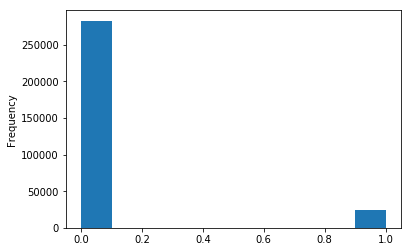

In [14]:
app_train['TARGET'].astype(int).plot.hist();

In [15]:
dist_targ = pd.DataFrame(app_train.groupby(['TARGET']).count()['SK_ID_CURR']).reset_index('TARGET')
dist_targ['TARGET'] = dist_targ['TARGET'].astype(int)
dist_targ['APPLICATIONS'] = dist_targ['SK_ID_CURR']
dist_targ.drop(['SK_ID_CURR'],axis=1)
dist_targ['perc'] = dist_targ['APPLICATIONS']/app_train['SK_ID_CURR'].count()
dist_targ

,TARGET,SK_ID_CURR,APPLICATIONS,perc
0,0,282686,282686,0.919271
1,1,24825,24825,0.080729


In [16]:
pd.DataFrame(app_train.groupby(['TARGET']).mean()['AMT_ANNUITY']).reset_index('TARGET')

,TARGET,AMT_ANNUITY
0,0,27163.623349
1,1,26481.744290


In [17]:
app_train[['AMT_ANNUITY','AMT_CREDIT']].describe()

,AMT_ANNUITY,AMT_CREDIT
count,307499.000000,3.075110e+05
mean,27108.573909,5.990260e+05
std,14493.737315,4.024908e+05
min,1615.500000,4.500000e+04
25%,16524.000000,2.700000e+05
50%,24903.000000,5.135310e+05
75%,34596.000000,8.086500e+05
max,258025.500000,4.050000e+06


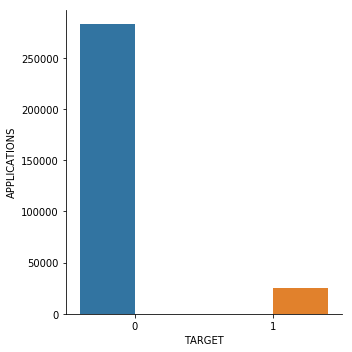

In [18]:
def format_spines(ax, right_border=True):
    """
    this function sets up borders from an axis and personalize colors
    """    
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

# Plotting
sns.catplot(x="TARGET", y="APPLICATIONS", hue="TARGET", kind="bar", data=dist_targ);


In [19]:
## Plotting
#fig, ax = plt.subplots(figsize=(8, 5))
#ax = sns.barplot(y='TARGET', x='APPLICATIONS', data=dist_targ, palette='Blues_d')
##ax.set_xlim([0, 30000])
#format_spines(ax, right_border=False)
#
#for p in ax.patches:
#    width = p.get_width()
#    ax.text(width+0.01, p.get_y() + p.get_height() / 2. + 0.2, '{:1.2f}'.format(width), 
#            ha="center", color='grey')
#
#ax.set_title('Top 10 Restaurants in Bengaluru', size=14)
#plt.show()

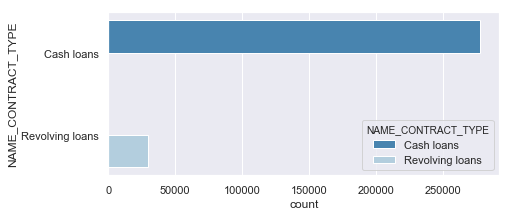

In [20]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="NAME_CONTRACT_TYPE", data=app_train, hue="NAME_CONTRACT_TYPE", palette="Blues_r");

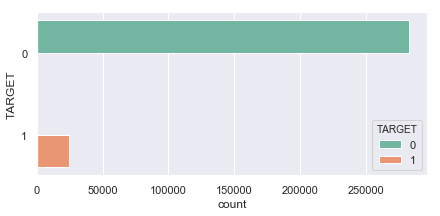

In [21]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="TARGET", data=app_train, palette="Set2",hue="TARGET");

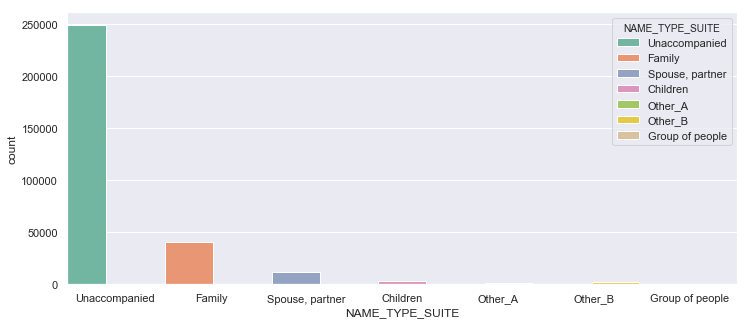

In [22]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(12, 5))
#fig, ax = plt.subplots()
sns.countplot(x="NAME_TYPE_SUITE", data=app_train, palette="Set2",hue="NAME_TYPE_SUITE")
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .5)
plt.show()

In [23]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 126 columns.
There are 71 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [25]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    69
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [26]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

In [27]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [28]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 247)
Testing Features shape:  (48744, 239)


Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to ```align``` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set ```axis = 1``` to align the dataframes based on the columns and not on the rows!

In [29]:
train_labels = app_train['TARGET']

## Align the training and testing data, keep only columns present in both dataframes
#app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
#
## Add the target back in
#app_train['TARGET'] = train_labels
#
print('Training Features shape: ', app_train.shape)
#print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 247)


# Back to Exploratory Data Analysis

**Anomalies**

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

In [30]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [31]:
(app_train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

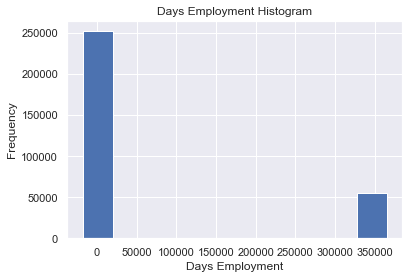

In [32]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [33]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (```np.nan```) and then create a new boolean column indicating whether or not the value was anomalous.

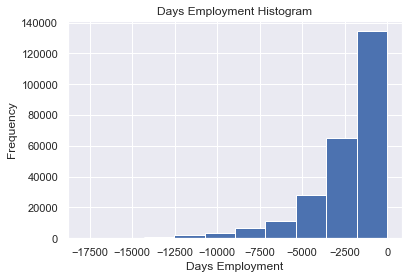

In [34]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with ```np.nan``` in the testing data.

In [35]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


**Correlations**

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”


In [36]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
active_bureau                  0.067128
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: f

Let's take a look at some of more significant correlations: the ```DAYS_BIRTH``` is the most positive correlation. (except for ```TARGET``` because the correlation of a variable with itself is always 1!) Looking at the documentation, ```DAYS_BIRTH``` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.



### Effect of Age on Repayment

In [37]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

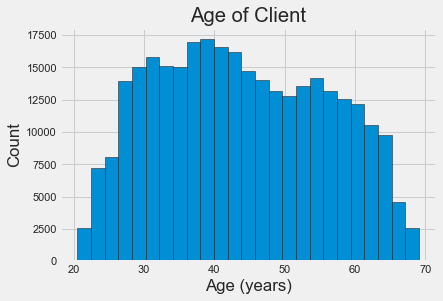

In [38]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

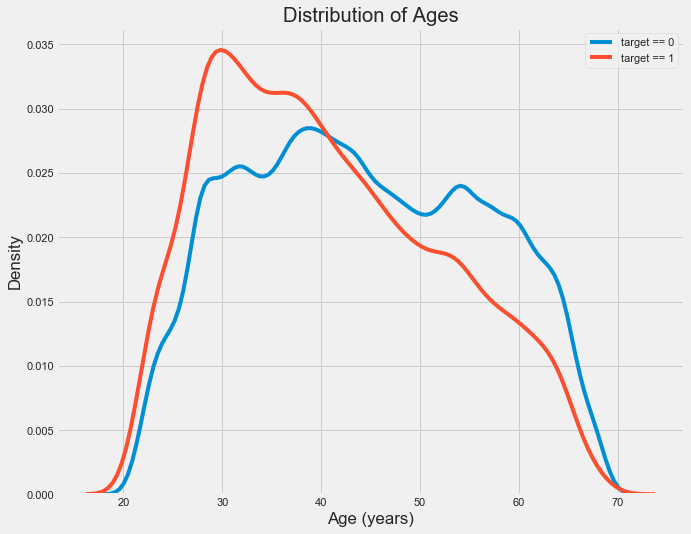

In [39]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [40]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [41]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


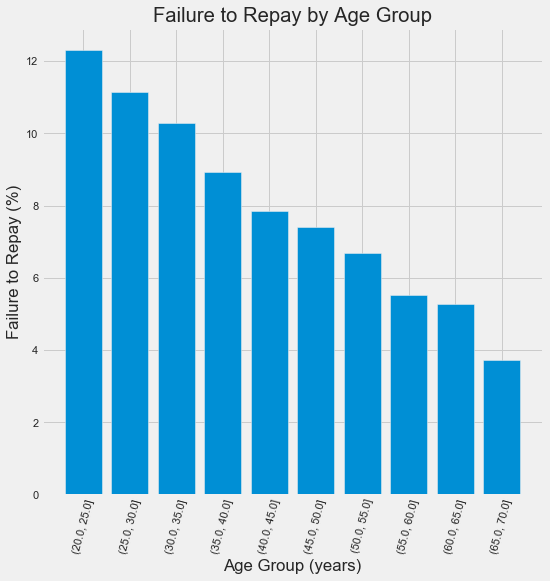

In [42]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

Exterior Sources
The 3 variables with the strongest negative correlations with the target are ```EXT_SOURCE_1```, ```EXT_SOURCE_2```, and ```EXT_SOURCE_3```. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the ```EXT_SOURCE``` features with the target and with each other.

In [43]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


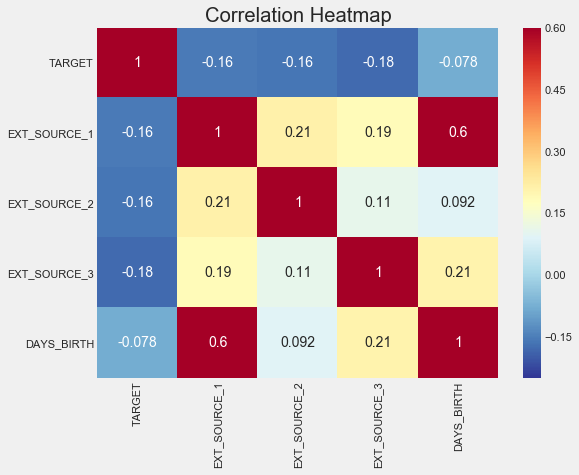

In [44]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three ```EXT_SOURCE``` featureshave negative correlations with the target, indicating that as the value of the ```EXT_SOURCE``` increases, the client is more likely to repay the loan. We can also see that ```DAYS_BIRTH``` is positively correlated with ```EXT_SOURCE_1``` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


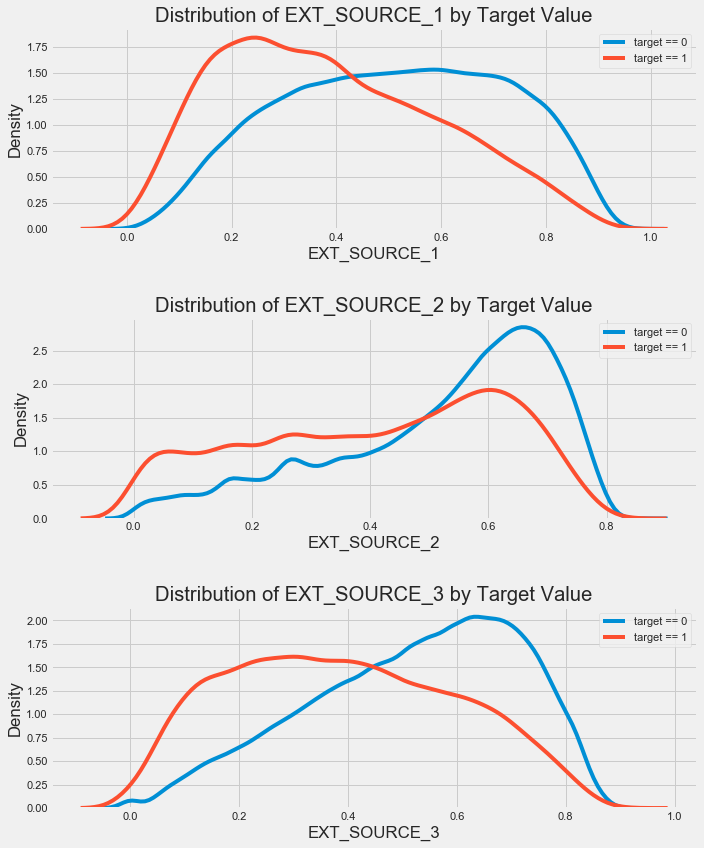

In [45]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

```EXT_SOURCE_3``` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

Pairs Plot
As a final exploratory plot, we can make a pairs plot of the ```EXT_SOURCE``` variables and the ```DAYS_BIRTH``` variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


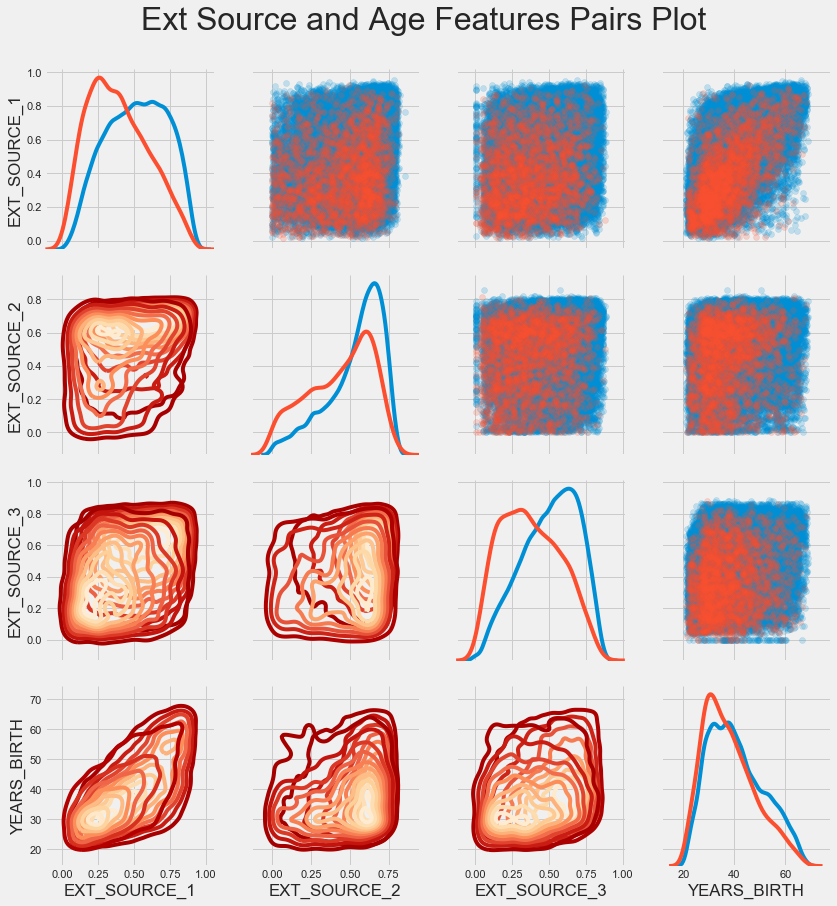

In [46]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the ```EXT_SOURCE_1``` and the ```DAYS_BIRTH``` (or equivalently ```YEARS_BIRTH```), indicating that this feature may take into account the age of the client.

In [47]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,1,0,1,0,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False


## Feature Engineering

In [48]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features ```get_feature_names``` method.

In [50]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [51]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [52]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


**Domain Knowledge Features**

- ```CREDIT_INCOME_PERCENT```: the percentage of the credit amount relative to a client's income
- ```ANNUITY_INCOME_PERCENT```: the percentage of the loan annuity relative to a client's income
- ```CREDIT_TERM```: the length of the payment in months (since the annuity is the monthly amount due
- ```DAYS_EMPLOYED_PERCENT```: the percentage of the days employed relative to the client's age
Again, thanks to Aguiar and his great script for exploring these features.

In [53]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [54]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [55]:
print(app_train.shape)
print(app_test.shape)

(307511, 248)
(48744, 240)


Visualize New Variables
We should explore these **domain knowledge** variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the ```TARGET```.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


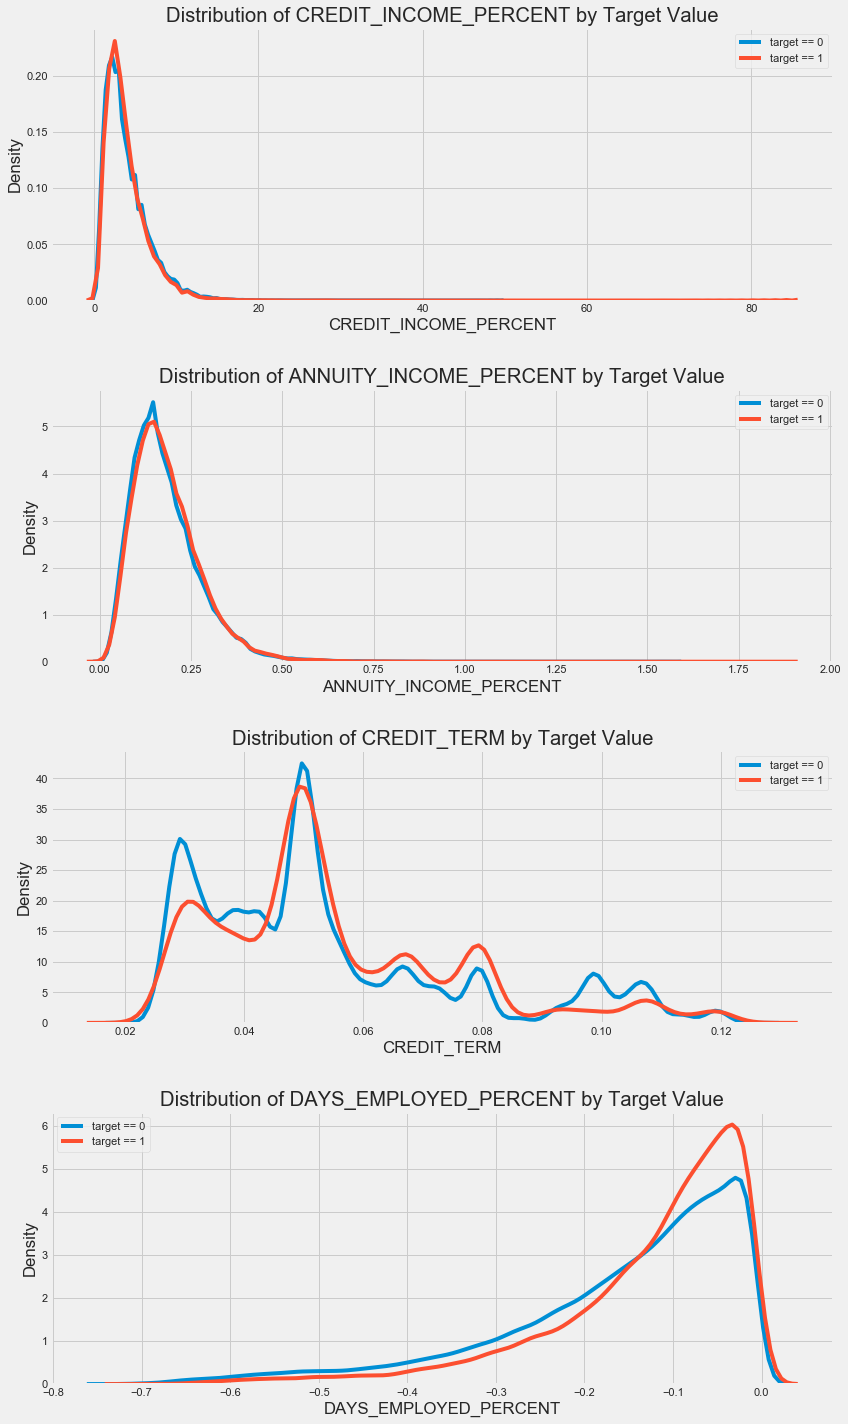

In [56]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

## Baseline



### Logistic Regression Implementation 
Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms.

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [57]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
target = app_train['TARGET'].copy()
# Feature names
features = list(train.columns)

# Copy of the testing data
#test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
#test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
#test = scaler.transform(test)

print('Training data shape: ', train.shape)
#print('Testing data shape: ', test.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 247)


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train,train_labels,random_state = 42,test_size=0.2)

In [60]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_LOGR = LogisticRegression(C = 0.0001)
model_LOGR.fit(X_train,y_train)
y_pred = model_LOGR.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score: 0.9195323805342829
Area under ROC Curve:  0.6853580675023014


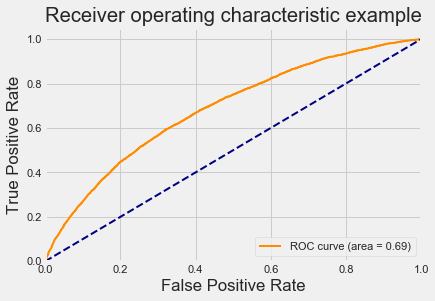

In [61]:
#Evaluating the model
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
df_logr = pd.DataFrame(model_LOGR.predict_proba(X_test))
df_logr.columns = ['p0','p1']
df_logr['actual'] = np.array(y_test)
fpr, tpr, thresholds = metrics.roc_curve(df_logr.actual, df_logr.p1, pos_label=1)

roc_auc = metrics.auc(fpr, tpr)
print('Area under ROC Curve: ',roc_auc)

#plotting ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

0.16143705848359868


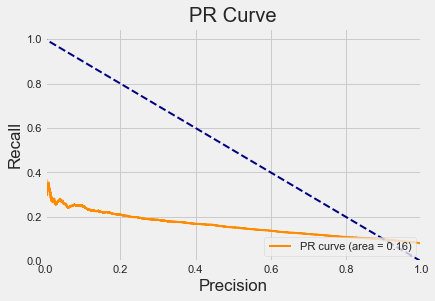

In [62]:
# Plot a PR curve
precision, recall, thresholds = metrics.precision_recall_curve(df_logr.actual, df_logr.p1, pos_label=1)
pr_auc = metrics.auc(recall, precision)
print(pr_auc)
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='PR curve (area = %0.2f)' % pr_auc)
plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.show()

### Improved Model: Random Forest

In [63]:
#Random Forest: oversample the minority data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(pd.DataFrame(y_train).groupby('TARGET').agg({'TARGET':'count'}))
print('Minority used to be: ', y_train.mean(),' of ' ,y_train.count() )
print('Minority now composes: ', y_train_res.mean(),' of ' ,len(y_train_res))

        TARGET
TARGET        
0       226132
1        19876
Minority used to be:  0.08079412051640597  of  246008
Minority now composes:  0.5  of  452264


In [64]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
model_RF.fit(X_train_res, y_train_res)
# Extract feature importances
feature_importance_values = model_RF.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
y_pred = model_RF.predict(X_test)
print(model_RF.classes_)
metrics.confusion_matrix(y_test,y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s


[0 1]


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished


array([[56415,   139],
       [ 4883,    66]], dtype=int64)

Confusion matrix, without normalization
[[56415   139]
 [ 4883    66]]
Normalized confusion matrix
[[1.   0.  ]
 [0.99 0.01]]


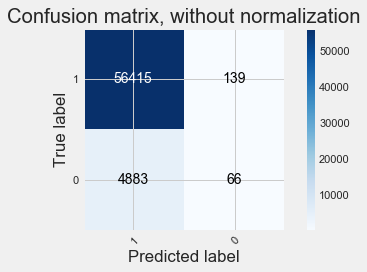

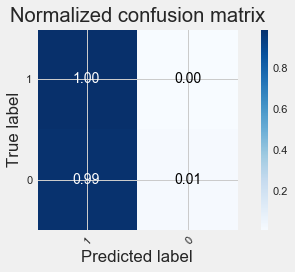

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_test, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=train_labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=train_labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [94]:
#Evaluating the model
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
df_rf = pd.DataFrame(model_RF.predict_proba(X_test))
df_rf.columns = ['p0','p1']
df_rf['actual'] = np.array(y_test)
fpr, tpr, thresholds = metrics.roc_curve(df_rf.actual, df_rf.p1, pos_label=1)

Accuracy Score: 0.9183454465635823


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


Area under ROC Curve:  0.701094136819672


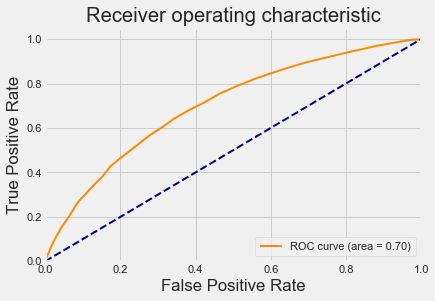

In [67]:
roc_auc = metrics.auc(fpr, tpr)
print('Area under ROC Curve: ',roc_auc)

#plotting ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

0.1707432193294416


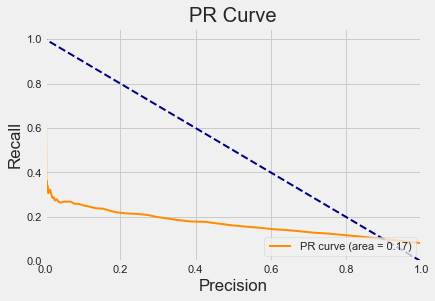

In [68]:
# Plot a PR curve
precision, recall, thresholds = metrics.precision_recall_curve(df_rf.actual, df_rf.p1, pos_label=1)
pr_auc = metrics.auc(recall, precision)
print(pr_auc)
plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='PR curve (area = %0.2f)' % pr_auc)
plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR Curve')
plt.legend(loc="lower right")
plt.show()

### Model Interpretation: Feature Importances
As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the ```EXT_SOURCE``` and the ```DAYS_BIRTH```. We may use these feature importances as a method of dimensionality reduction in future work.

In [69]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

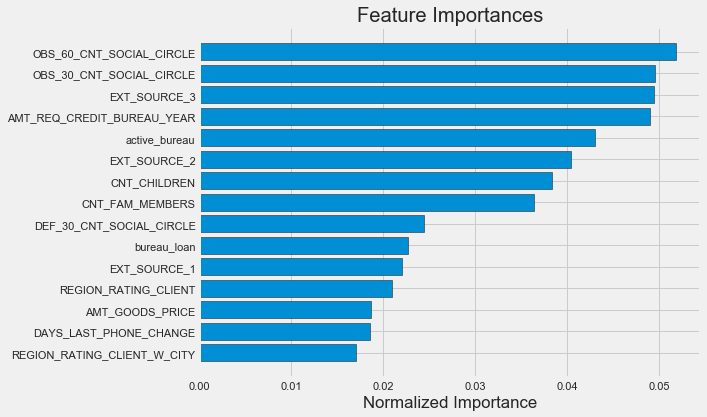

In [70]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [72]:
features_to_consider = feature_importances.sort_values('importance',ascending=False).head(10) 

In [73]:
features_to_consider.to_csv('./output/features.csv')

In [74]:
feature_importances.sort_values('importance',ascending=False).tail(10)

,feature,importance
109,bad_debt,3.056243e-06
124,NAME_INCOME_TYPE_Maternity leave,2.348243e-06
127,NAME_INCOME_TYPE_Student,7.438792e-07
84,FLAG_DOCUMENT_4,2.055809e-07
90,FLAG_DOCUMENT_10,1.552227e-07
114,CODE_GENDER_XNA,8.744047e-08
122,NAME_INCOME_TYPE_Businessman,0.000000e+00
92,FLAG_DOCUMENT_12,0.000000e+00
15,FLAG_MOBIL,0.000000e+00
139,NAME_FAMILY_STATUS_Unknown,0.000000e+00


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


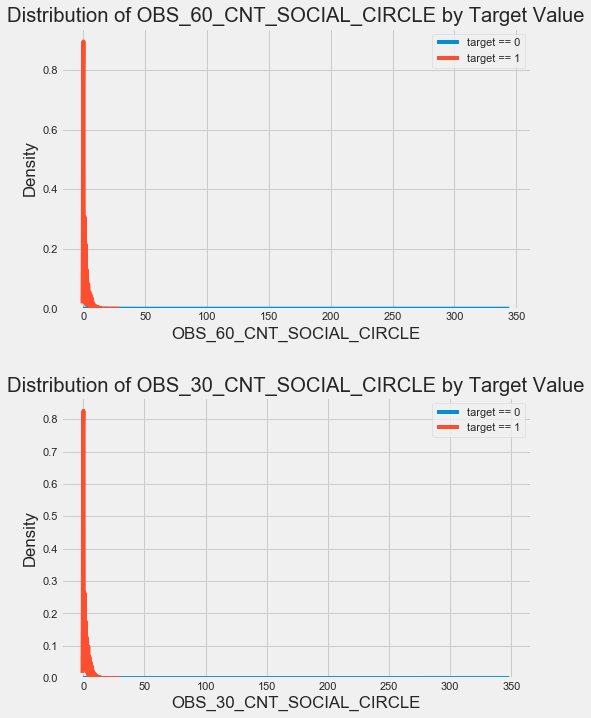

In [75]:
plt.figure(figsize = (8, 20))
# iterate through the new features
for i, feature in enumerate(['OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

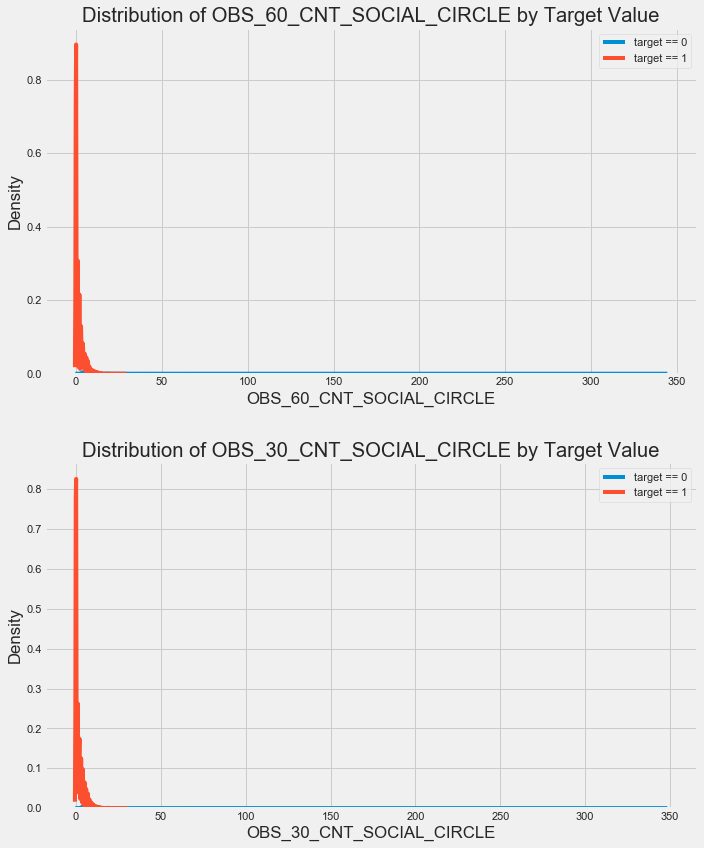

In [76]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']):
    
    # create a new subplot for each source
    plt.subplot(2, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [77]:
#import seaborn as sns
#plt.figure(figsize=(8, 8))
#sns.set_context("paper", font_scale=2.5) 
#ax = sns.boxplot(x=app_train['TARGET'], y=app_train['OBS_60_CNT_SOCIAL_CIRCLE'],data=app_train)
#plt.savefig("test.svg", format="svg")

In [78]:
app_train.groupby(['TARGET']).mean()['DEF_30_CNT_SOCIAL_CIRCLE']

TARGET
0    0.139148
1    0.191980
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

In [79]:
##from sklearn.preprocessing import RobustScaler
##from imblearn.under_sampling import RandomUnderSample
### Impute the missing data using features means
##imp = Imputer()
##imp.fit(X_train)
##X_train = imp.transform(X_train)
##X_test = imp.transform(X_test)
##
### Standardize the data
##std = RobustScaler()
##std.fit(X_train)
##X_train = std.transform(X_train)
##X_test = std.transform(X_test)
##
### Implement RandomUnderSampler
##random_undersampler = RandomUnderSampler()
##X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import StratifiedKFold
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import VotingClassifier
#from sklearn import svm
#import xgboost as xgb
##xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic')
#
## Shuffle the data
#perms = np.random.permutation(X_train_res.shape[0])
##X_train_res
##y_train_res
#X_res = X_train_res[perms]
#y_res = y_train_res[perms]
#
## Define base learners
#xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
#                            learning_rate=0.03,
#                            n_estimators=500,
#                            max_depth=1,
#                            subsample=0.4,
#                            random_state=123)
#svm_clf = svm.SVC(gamma=0.1,
#              C=0.01,
#              kernel="poly",
#              degree=3,
#              coef0=10.0,
#              probability=True)
#rf_clf = RandomForestClassifier(n_estimators=300,
#                                max_features="sqrt",
#                                criterion="gini",
#                                min_samples_leaf=5,
#                                class_weight="balanced")
#
## Define meta-learner
#logreg_clf = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
## Fitting voting clf --> average ensemble
#voting_clf = VotingClassifier([("xgb", xgb_clf),
#                               ("svm", svm_clf),
#                               ("rf", rf_clf)],
#                              voting="soft",
#                              flatten_transform=True)
#voting_clf.fit(X_res, y_res)
#xgb_model, svm_model, rf_model = voting_clf.estimators_
#models = {"xgb": xgb_model,
# /''         "svm": svm_model,
#          "rf": rf_model,
#          "avg_ensemble": voting_clf}
#
## Build first stack of base learners
#first_stack = make_pipeline(voting_clf,
#                            FunctionTransformer(lambda X: X[:, 1::2]))
#
## Use CV to generate meta-features
#meta_features = cross_val_predict(first_stack, X_res, y_res, cv=10, method="transform")
#
## Refit the first stack on the full training set
#first_stack.fit(X_res, y_res)
#
## Fit the meta learner
#second_stack = logreg_clf.fit(meta_features, y_res)
#
## Plot ROC and PR curves using all models and test data
#fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#for name, model in models.items():
#  model_probs = model.predict_proba(X_test)[:, 1:]
#  model_auc_score = roc_auc_score(y_test, model_probs)
#  fpr, tpr, _ = roc_curve(y_test, model_probs)
#  precision, recall, _ = precision_recall_curve(y_test, model_probs)
#  axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
#  axes[1].plot(recall, precision, label=f"{name}")
#
#stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
#stacked_auc_score = roc_auc_score(y_test, stacked_probs)
#fpr, tpr, _ = roc_curve(y_test, stacked_probs)
#precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
#axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
#axes[1].plot(recall, precision, label="stacked_ensembe")
#axes[0].legend(loc="lower right")
#axes[0].set_xlabel("FPR")
#axes[0].set_ylabel("TPR")
#axes[0].set_title("ROC curve")
#axes[1].legend()
#axes[1].set_xlabel("recall")
#axes[1].set_ylabel("precision")
#axes[1].set_title("PR curve")
#plt.tight_layout()

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.32      0.01      0.03      4949

   micro avg       0.92      0.92      0.92     61503
   macro avg       0.62      0.51      0.49     61503
weighted avg       0.87      0.92      0.88     61503



In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create a knn model
knn = KNeighborsClassifier()
#knn.fit(X_train,y_train)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

In [ ]:
##fit model to data
#knn_gscv.fit(X_train, y_train)

In [88]:
df_auc_roc = pd.DataFrame(fpr, tpr).reset_index()
df_auc_roc.columns = ['fpr','tpr']


In [90]:
df_auc_roc.to_csv('auc_roc.csv')

In [92]:
df_auc_roc.head()

,fpr,tpr
0,0.000000,0.000000
1,0.000202,0.000000
2,0.000202,0.000018
3,0.000404,0.000035
4,0.001010,0.000053


In [93]:
roc_auc

0.701094136819672